# Supervised Representation Learning 

In this tutorial we show how to perform supervised representation learning using a VGGish Network.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = "/home/han/Database/tensorflow_datasets"  # default location of tfds database

import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

# Turn off logging for TF
import logging
tf.get_logger().setLevel(logging.ERROR)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())


In [2]:
import dpmhm
# dpmhm.datasets.get_dataset_list()

from dpmhm.datasets import preprocessing, feature, utils

## Load the CWRU dataset

We use the CWRU dataset for this tutorial. Suppose it has been correctly installed. We load it using the method `tfds.load()`.

In [3]:
dataset_name = 'CWRU'

ds_all, ds_info = tfds.load(
    dataset_name,
    with_info=True,
)

ds0 = ds_all['train']

2023-03-17 11:18:20.824395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Preprocessing pipeline

Next let's define a preprocessing pipeline consisting of
- selecting data files that contain simultaneously all 3 channels & label ramification
- feature extraction: compute the spectrogram
- sliding window view that yields patches of fixed dimension

In [4]:
from dpmhm.datasets import transformer, feature

compactor = transformer.DatasetCompactor(ds0,
                                         channels=['DE', 'FE', 'BA'],
                                         keys=['FaultLocation', 'FaultComponent', 'FaultSize'],
                                         resampling_rate=12000)

# Feature extractor
# Spectrogram is computed on a time window of 0.025 second every 0.0125 second, then converted to decibel scale.
_func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram',
#                                                 n_mfcc=256,
                                                time_window=0.025, hop_step=0.0125, n_fft=512,
                                                normalize=False, to_db=True)[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# A window of width w correspond to w*0.0125 seconds
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))
# window = transformer.WindowSlider(extractor.dataset, window_size=(256, 80), hop_size=40)  # 1s, full bandwidth
# window = transformer.WindowSlider(extractor.dataset, window_size=64, hop_size=32)

Here's how the spectrogram patches look like:

In [5]:
eles = list(window.dataset.take(10).as_numpy_iterator())

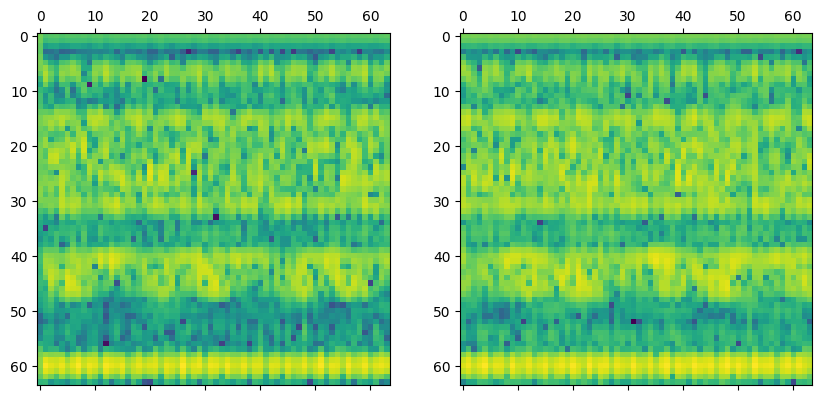

In [6]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].matshow(eles[0]['feature'][0])
axes[1].matshow(eles[9]['feature'][0])

Next split the dataset and define a Keras preprocessing model that is necessary for converting the dataset to appropriate format for training.

In [7]:
splits = {'train':0.7, 'val':0.2, 'test':0.1}

%time dw_split = utils.split_dataset(window.dataset, splits)

CPU times: user 42.1 s, sys: 1.24 s, total: 43.3 s
Wall time: 10.4 s


In [8]:
labels = list(compactor.full_label_dict.keys())  # need the whole list of labels
print("Number of classes:", len(labels))

preprocessing_model = preprocessing.keras_model_supervised(dw_split['train'], labels, normalize=False)

Number of classes: 29


After preprocessing by the Keras model, the dataset has tuple `(feature, label)` as element and is in the channel-last format.

In [9]:
ds_split = {}

for k,v in dw_split.items():
    ds_split[k] = v.map(preprocessing_model, num_parallel_calls=tf.data.AUTOTUNE)#.map(lambda x,y: (x, y-1))

In [10]:
ds_split['train'].element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Finally create the training/validation/test set with mini-batches.

In [11]:
batch_size = 16

ds_size = 20000  # use a large number
ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size)
ds_test = ds_split['test'].batch(1)

In [12]:
ds_train.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## Train a VGGish network

Note that the Keras preprocessing model included an outlier class (of label `0`) in the final dataset, we must accordingly increase the number of classes by 1.

In [13]:
eles = list(ds_split['train'].take(10).as_numpy_iterator())
input_shape = eles[0][0].shape
n_classes = len(labels)+1  # must add one for the outlier class, Keras uses zero-based class labels.

print(input_shape)  # data is in channel-last format
print(n_classes)

(64, 64, 3)
30


### Implementation 1: Keras pretrained model with transfer learning

Keras comes with a VGG16 model pretrained on Imagenet that can be reused for feature embedding. We load and freeze the pretrained weights and perform transfer learning only on final classification layers.

In [14]:
from tensorflow.keras.applications import VGG16

In [15]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape, classes=n_classes)

base_model.trainable = False

inputs = base_model.layers[0].input
# layer = keras.layers.BatchNormalization()
# layer.build((None, 4))  # Create the weights

x = base_model(inputs, training=False)
x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(4096, activation="relu", name="fc1")(x)
x = keras.layers.Dense(4096, activation="relu", name="fc2")(x)
outputs = keras.layers.Dense(n_classes, activation=None, name="predictions")(x)

model = keras.Model(inputs, outputs)

from_logits = 'softmax' not in str(model.get_layer('predictions').activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [16]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/10
713/713 [==============================] - 208s 282ms/step - loss: 1.1681 - accuracy: 0.7069 - val_loss: 0.2175 - val_accuracy: 0.9270
Epoch 2/10
713/713 [==============================] - 178s 250ms/step - loss: 0.2721 - accuracy: 0.9122 - val_loss: 0.4479 - val_accuracy: 0.8791
Epoch 3/10
713/713 [==============================] - 186s 261ms/step - loss: 0.2432 - accuracy: 0.9314 - val_loss: 0.2652 - val_accuracy: 0.9150
Epoch 4/10
713/713 [==============================] - 195s 273ms/step - loss: 0.1649 - accuracy: 0.9519 - val_loss: 0.1706 - val_accuracy: 0.9491
Epoch 5/10
713/713 [==============================] - 193s 270ms/step - loss: 0.1383 - accuracy: 0.9638 - val_loss: 0.2170 - val_accuracy: 0.9457
Epoch 6/10
713/713 [==============================] - 174s 244ms/step - loss: 0.1350 - accuracy: 0.9619 - val_loss: 0.3071 - val_accuracy: 0.9365
Epoch 7/10
713/713 [==============================] - 172s 242ms/step - loss: 0.1465 - accuracy: 0.9671 - val_loss: 0.1017 -

In [17]:
model.save('/home/han/tmp/vggish_[64x64x3]')

In [18]:
model.evaluate(ds_test)

1630/1630 [==============================] - 33s 16ms/step - loss: 0.2073 - accuracy: 0.9595


[0.20728285610675812, 0.9595091938972473]

#### Fine tuning

After training, we can perform several steps of fine tuning with a small learning rate.

In [19]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [20]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=2,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/2
713/713 [==============================] - 454s 633ms/step - loss: 0.1665 - accuracy: 0.9604 - val_loss: 0.2006 - val_accuracy: 0.9521
Epoch 2/2
713/713 [==============================] - 459s 643ms/step - loss: 0.0477 - accuracy: 0.9876 - val_loss: 0.0283 - val_accuracy: 0.9914


In [21]:
model.evaluate(ds_test)

1630/1630 [==============================] - 33s 16ms/step - loss: 0.0260 - accuracy: 0.9939


[0.025987833738327026, 0.9938650131225586]

### Implementation 2: DPMHM

In `dpmhm` we provide also an implementation of the VGGish network. Unlike the Keras implementation, weights are not pretrained here so the training may be longer. 

In [19]:
from dpmhm.models.sl import vggish

In [24]:
config = vggish.Config(input_shape=input_shape, n_embedding=128, n_classes=n_classes, padding='same', activation='relu',)
model = vggish.VGG11(config)

print(config)

model.summary()

# l=model.get_layer('classifier')

Config(input_shape=(257, 64, 3), batch_size=256, epochs=100, training_steps=1000, n_classes=30, n_embedding=128, kernel_size=(3, 3), activation='relu', activation_classifier=None, padding='same', pool_size=(2, 2), strides=(2, 2))
Model: "VGGish-A"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 257, 64, 64)       1792      
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 32, 64)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 128)      73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 16, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 64, 16, 256)       295168    
                          

In [25]:
from_logits = 'softmax' not in str(model.get_layer('classifier').activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [26]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)


Epoch 1/100
102/102 [==============================] - 118s 1s/step - loss: 8.5708 - accuracy: 0.0540 - val_loss: 2.4979 - val_accuracy: 0.1763
Epoch 2/100
102/102 [==============================] - 101s 991ms/step - loss: 0.8795 - accuracy: 0.7299 - val_loss: 0.2445 - val_accuracy: 0.9247
Epoch 3/100
102/102 [==============================] - 106s 1s/step - loss: 0.4085 - accuracy: 0.9104 - val_loss: 0.1286 - val_accuracy: 0.9656
Epoch 4/100
102/102 [==============================] - 104s 1s/step - loss: 0.1904 - accuracy: 0.9490 - val_loss: 0.1060 - val_accuracy: 0.9548
Epoch 5/100
102/102 [==============================] - 89s 876ms/step - loss: 0.2692 - accuracy: 0.9374 - val_loss: 0.2231 - val_accuracy: 0.9548
Epoch 6/100
102/102 [==============================] - 90s 880ms/step - loss: 0.0859 - accuracy: 0.9877 - val_loss: 0.0154 - val_accuracy: 0.9978
Epoch 7/100
102/102 [==============================] - 88s 865ms/step - loss: 6.3219e-04 - accuracy: 1.0000 - val_loss: 4.8244e-0

In [28]:
# model.save()
# model = keras.models.load_model('/home/han/tmp/cwru/vggish')

In [27]:
model.evaluate(ds_test)

15/15 [==============================] - 7s 181ms/step - loss: 2.0836e-07 - accuracy: 1.0000


[2.0836100134147273e-07, 1.0]